# Curate, merge and visualize datasets

Here we will load 3 datasets, curate the rows, and visualize some basic tenets of the data. Your starting dataset should have columns including:
- unique compound identifier
- smiles strings (see https://pubchem.ncbi.nlm.nih.gov/idexchange/idexchange.cgi for a good lookup service)
- an assay measurement value, ie pIC50
- labels like "active" or "inactive" or another label you want, such as the source of the data.
- for censored measurement values, a "relation" column with "<" or ">" indicating where the value is censored (based on the pIC50 value, not original)

# Load packages, define functions

In [1]:
# manipulate data
import pandas as pd

# plot data
import matplotlib.pyplot as plt

# curate data
import atomsci.ddm.utils.struct_utils as struct_utils
import atomsci.ddm.utils.curate_data as curate_data

# visualize compound structures
import tempfile
from rdkit import Chem
from rdkit.Chem import Draw
from itertools import islice
from IPython.display import Image, display

In [2]:
# functions for displaying molecule images
def display_images(filenames):
    """Helper to pretty-print images."""
    for file in filenames:
      display(Image(file))

def mols_to_pngs(mols, basename="test"):
    """Helper to write RDKit mols to png files."""
    filenames = []
    for i, mol in enumerate(mols):
        filename = "%s%d.png" % (basename, i)
        Draw.MolToFile(mol, filename)
        filenames.append(filename)
    return filenames

# Curating and merging datasets
Some of these merging steps will be highly dependent on the information contained in each individual dataset and what you want to keep after curation.

### **Step 0:** Read dataset
Read in dataset to be curated and merged. 

### Step 1: Initial curation for nan's and outliers
Drop NA values for assay measurement column. Here you should also examine empty quotes, unexpected zeros, or other values that might not be real.

### **Step 2:** Canonicalize smiles strings
Canonicalize smiles strings so they are comparable across datasets with `struct_utils.base_smiles_from_smiles`. Even though the next function performs this step, we need to do this here in order to maintain correct metadata indices.

In [3]:
# MRP3
# read in file:
df3 = pd.read_excel('/Users/paulsonak/Documents/AMPL_mrp34/CRADA/MRP34_full.xlsx', sheet_name="MRP3_full")

# drop NA's
df3 = df3[~df3['pIC50_MRP3'].isna()]
df3 = df3.reset_index(drop = True)

# canonicalize smiles strings:
df3['base_rdkit_smiles'] = df3['smiles'].apply(struct_utils.base_smiles_from_smiles)

# look at length of dataset and duplicates.
print("DF3 length:", len(df3), "Non-duplicates:", len(df3['base_rdkit_smiles'].unique()))

df3

RDKit ERROR: [14:49:39] Can't kekulize mol.  Unkekulized atoms: 3 10
RDKit ERROR: 


DF3 length: 822 Non-duplicates: 799


,base_smiles,alt_smiles,smiles,smiles_takeAlt,compound_id_pubchem,pIC50_MRP3,pIC50_MRP3_avg,relation_MRP3,active_MRP3,source_pmid,Morgan,SMDC,Proprietary,base_rdkit_smiles
0,NaN,NaN,[Na+].CC(C)Oc1ccc(cc1C#N)-c1nc(no1)-c1ccc2CN(C...,[Na+].CC(C)Oc1ccc(cc1C#N)-c1nc(no1)-c1ccc2CN(C...,000149_1,6.20,6.20,NaN,1,SMDC,0,1,1,Cc1c(-c2noc(-c3ccc(OC(C)C)c(C#N)c3)n2)ccc2c1CC...
1,C(=C/c1ccccc1)\CN1CCN(C(c2ccccc2)c2ccccc2)CC1,NaN,C(=C/c1ccccc1)\CN1CCN(C(c2ccccc2)c2ccccc2)CC1,C(=C/c1ccccc1)\CN1CCN(C(c2ccccc2)c2ccccc2)CC1,1547484,3.88,3.88,<,0,23956101,1,0,0,C(=C/c1ccccc1)\CN1CCN(C(c2ccccc2)c2ccccc2)CC1
2,C[C@](N)(Cc1ccc(O)c(O)c1)C(=O)O.O,NaN,C[C@](N)(Cc1ccc(O)c(O)c1)C(=O)O.O,C[C@](N)(Cc1ccc(O)c(O)c1)C(=O)O.O,18530292,4.38,4.38,NaN,1,23956101,1,0,0,C[C@](N)(Cc1ccc(O)c(O)c1)C(=O)O
3,C[C@]12C[C@H](O)[C@H]3[C@@H](CCC4=CC(=O)C=C[C@...,NaN,C[C@]12C[C@H](O)[C@H]3[C@@H](CCC4=CC(=O)C=C[C@...,C[C@]12C[C@H](O)[C@H]3[C@@H](CCC4=CC(=O)C=C[C@...,5755,3.88,3.88,<,0,23956101,1,0,0,C[C@]12C[C@H](O)[C@H]3[C@@H](CCC4=CC(=O)C=C[C@...
4,C[C@]12C/C(=C/O)C(=O)C[C@@H]1CC[C@@H]1[C@@H]2C...,NaN,C[C@]12C/C(=C/O)C(=O)C[C@@H]1CC[C@@H]1[C@@H]2C...,C[C@]12C/C(=C/O)C(=O)C[C@@H]1CC[C@@H]1[C@@H]2C...,5281034,3.88,3.88,<,0,23956101,1,0,0,C[C@]12C/C(=C/O)C(=O)C[C@@H]1CC[C@@H]1[C@@H]2C...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
817,OCCN1C[C@H](O)[C@@H](O)[C@H](O)[C@H]1CO,NaN,OCCN1C[C@H](O)[C@@H](O)[C@H](O)[C@H]1CO,OCCN1C[C@H](O)[C@@H](O)[C@H](O)[C@H]1CO,441314,3.88,3.88,<,0,23956101,1,0,0,OCCN1C[C@H](O)[C@@H](O)[C@H](O)[C@H]1CO
818,OCCN1CCN(CCCN2c3ccccc3Sc3ccc(Cl)cc32)CC1,NaN,OCCN1CCN(CCCN2c3ccccc3Sc3ccc(Cl)cc32)CC1,OCCN1CCN(CCCN2c3ccccc3Sc3ccc(Cl)cc32)CC1,4748,3.88,3.88,<,0,23956101,1,0,0,OCCN1CCN(CCCN2c3ccccc3Sc3ccc(Cl)cc32)CC1
819,NaN,NaN,OS(O)(=O)=O.CC(C)[C@H](N)C(=O)O[C@@H](C)C(=O)O...,OS(O)(=O)=O.CC(C)[C@H](N)C(=O)O[C@@H](C)C(=O)O...,000111_1,4.21,4.21,NaN,1,SMDC,0,1,1,CC(C)[C@H](N)C(=O)O[C@@H](C)C(=O)OC[C@H]1O[C@@...
820,S=C=Nc1cccc2ccccc12,NaN,S=C=Nc1cccc2ccccc12,S=C=Nc1cccc2ccccc12,11080,3.88,3.88,<,0,23956101,1,0,0,S=C=Nc1cccc2ccccc12


### **Step 3:** Preserve and aggregate metadata
Split off metadata from parent dataframe and aggregate labels.

In [7]:
df3_metadata = df3[["base_rdkit_smiles", "source_pmid", "Morgan", "SMDC", "Proprietary"]]
print("Original length:",len(df3_metadata))

df3_metadata = df3_metadata.groupby(by = "base_rdkit_smiles", as_index = False).sum()
print("Deduplicated length:",len(df3_metadata))

df3_metadata

Original length: 822
Deduplicated length: 799


,base_rdkit_smiles,Morgan,SMDC,Proprietary
0,C#CCN(C)[C@H](C)Cc1ccccc1,1,0,0
1,C#CCN[C@@H]1CCc2ccccc21,1,0,0
2,C#C[C@@]1(O)CC[C@H]2[C@@H]3CCC4=CC(=O)CC[C@@H]...,1,0,0
3,C#C[C@@]1(O)CC[C@H]2[C@@H]3CCC4=Cc5oncc5C[C@]4...,1,0,0
4,C#C[C@@]1(OC(C)=O)CC[C@H]2[C@@H]3CCC4=CC(=O)CC...,1,0,0
...,...,...,...,...
794,c1ccc(-c2ccc(C(c3ccccc3)n3ccnc3)cc2)cc1,1,0,0
795,c1ccc(C2(c3ccccc3)CC2C2=NCCN2)cc1,1,0,0
796,c1ccc2c(c1)OCC(C1=NCCN1)O2,1,0,0
797,c1cnc(N2CCN(Cc3ccc4c(c3)OCO4)CC2)nc1,1,0,0


### **Step 4:** Aggregate assay data
Use the `aggregate_assay_data()` function to aggregate duplicate assay measurements, deal with censored values, and standardize measurement dataframe for modeling later. This method also re-does the canonical smiles strings. *Even if you know you have no duplicates, still perform this step to standardize the dataframe.*

### **Step 5:** Merge metadata back in
Merge metadata with aggregated assay data.

In [8]:
df3_model = curate_data.aggregate_assay_data(df3, 
                         value_col='pIC50_MRP3', 
                         output_value_col='pIC50_MRP3',
                         label_actives=True, 
                         active_thresh=4,
                         id_col='compound_id_pubchem', 
                         smiles_col='base_rdkit_smiles', 
                         relation_col='relation_MRP3', 
                         date_col=None)
df3_model

df3_cur = pd.merge(df3_model, df3_metadata)
print("Shape of curated dataframe:", df3_cur.shape)

df3_cur

0 entries in input table are missing SMILES strings


RDKit ERROR: [14:50:30] Can't kekulize mol.  Unkekulized atoms: 3 10
RDKit ERROR: 


799 unique SMILES strings are reduced to 799 unique base SMILES strings
Shape of curated dataframe: (799, 8)


,compound_id,base_rdkit_smiles,relation,pIC50_MRP3,active,Morgan,SMDC,Proprietary
0,28061,Cc1ncc([N+](=O)[O-])n1CC(O)CCl,<,3.88,0,1,0,0
1,441130,C[C@@H](O)[C@H]1C(=O)N2C(C(=O)O)=C(S[C@@H]3CN[...,<,3.88,0,1,0,0
2,1355,Clc1cccc(N2CCNCC2)c1,<,3.88,0,1,0,0
3,000165_1,COc1ccc(N2CCN(Cc3nc(-c4ccc(C(F)(F)F)cc4)sc3CSc...,,4.42,1,0,1,1
4,5379,COc1c(N2CCNC(C)C2)c(F)cc2c(=O)c(C(=O)O)cn(C3CC...,<,3.88,0,1,0,0
...,...,...,...,...,...,...,...,...
794,5280723,CCCCC[C@H](O)/C=C/[C@H]1[C@H](O)CC(=O)[C@@H]1C...,,4.57,1,1,0,0
795,2378,c1ccc(-c2ccc(C(c3ccccc3)n3ccnc3)cc2)cc1,<,3.88,0,1,0,0
796,23675322,Cc1nnc(SCC2=C(C(=O)[O-])N3C(=O)[C@@H](NC(=O)Cn...,<,3.88,0,1,0,0
797,39764,CC(=O)O[C@H]1C[C@@H]2CC[C@@H]3[C@H](CC[C@@]4(C...,<,3.88,0,1,0,0


### Step 5.5: Repeat
**Repeat** steps 1-5 for all dataframes you want to curate and merge.

In [9]:
# MRP4
df4 = pd.read_excel('/Users/paulsonak/Documents/AMPL_mrp34/CRADA/MRP34_full.xlsx', sheet_name="MRP4_full")

df4 = df4[~df4['pIC50_MRP4'].isna()]

df4['base_rdkit_smiles'] = df4['smiles'].apply(struct_utils.base_smiles_from_smiles)
print("DF4 length:", len(df4), "Non-duplicates:", len(df4["base_rdkit_smiles"].unique()))

df4_metadata = df4[["base_rdkit_smiles", "Morgan", "SMDC", "Proprietary"]]
print("Original length:",len(df4_metadata))

df4_metadata = df4_metadata.groupby(by = "base_rdkit_smiles", as_index = False).sum()
print("Deduplicated length:",len(df4_metadata))

df4_model = curate_data.aggregate_assay_data(df4, 
                         value_col='pIC50_MRP4', 
                         output_value_col='pIC50_MRP4',
                         label_actives=True, 
                         active_thresh=4,
                         id_col='compound_id_pubchem', 
                         smiles_col='base_rdkit_smiles', 
                         relation_col='relation_MRP4', 
                         date_col=None)

df4_cur = pd.merge(df4_model, df4_metadata)
print("Shape of curated dataframe:", df4_cur.shape)

RDKit ERROR: [14:50:33] Can't kekulize mol.  Unkekulized atoms: 3 10
RDKit ERROR: 


DF4 length: 847 Non-duplicates: 816
Original length: 847
Deduplicated length: 816
0 entries in input table are missing SMILES strings


RDKit ERROR: [14:50:36] Can't kekulize mol.  Unkekulized atoms: 3 10
RDKit ERROR: 


816 unique SMILES strings are reduced to 816 unique base SMILES strings
Shape of curated dataframe: (816, 8)


In [10]:
# BSEP
dfb = pd.read_excel('/Users/paulsonak/Documents/AMPL_mrp34/CRADA/MRP34_full.xlsx', sheet_name="BSEP_full")

dfb = dfb[~dfb['pIC50_BSEP'].isna()]

dfb['base_rdkit_smiles'] = dfb['smiles'].apply(struct_utils.base_smiles_from_smiles)
print("DFB length:", len(dfb), "Non-duplicates:", len(dfb["base_rdkit_smiles"].unique()))

dfb_metadata = dfb[["base_rdkit_smiles", "Morgan", "SMDC", "Proprietary"]]
print("Original length:",len(dfb_metadata))

dfb_metadata = dfb_metadata.groupby(by = "base_rdkit_smiles", as_index = False).sum()
print("Deduplicated length:",len(dfb_metadata))

dfb_model = curate_data.aggregate_assay_data(dfb, 
                         value_col='pIC50_BSEP', 
                         output_value_col='pIC50_BSEP',
                         label_actives=True, 
                         active_thresh=4,
                         id_col='compound_id_pubchem', 
                         smiles_col='base_rdkit_smiles', 
                         relation_col='relation_BSEP', 
                         date_col=None)

dfb_cur = pd.merge(dfb_model, dfb_metadata)
print("Shape of curated dataframe:", dfb_cur.shape)

RDKit ERROR: [14:50:45] Can't kekulize mol.  Unkekulized atoms: 3 10
RDKit ERROR: 


DFB length: 1869 Non-duplicates: 1316
Original length: 1869
Deduplicated length: 1316
0 entries in input table are missing SMILES strings


RDKit ERROR: [14:50:49] Can't kekulize mol.  Unkekulized atoms: 3 10
RDKit ERROR: 


1316 unique SMILES strings are reduced to 1316 unique base SMILES strings
Shape of curated dataframe: (1316, 8)


### **Step 6:**  Merge datasets
Merge processed assay values together for each dataframe.

In [11]:
merge1 = pd.merge(df3_model, df4_model, how="outer", on = ("base_rdkit_smiles", "compound_id"), suffixes = ("_MRP3", "_MRP4"))
print("Shape of merge1 dataframe:", merge1.shape)
merge1

Shape of merge1 dataframe: (819, 8)


,compound_id,base_rdkit_smiles,relation_MRP3,pIC50_MRP3,active_MRP3,relation_MRP4,pIC50_MRP4,active_MRP4
0,28061,Cc1ncc([N+](=O)[O-])n1CC(O)CCl,<,3.88,0.0,<,3.880000,0.0
1,441130,C[C@@H](O)[C@H]1C(=O)N2C(C(=O)O)=C(S[C@@H]3CN[...,<,3.88,0.0,<,3.880000,0.0
2,1355,Clc1cccc(N2CCNCC2)c1,<,3.88,0.0,<,3.880000,0.0
3,000165_1,COc1ccc(N2CCN(Cc3nc(-c4ccc(C(F)(F)F)cc4)sc3CSc...,,4.42,1.0,,5.310000,1.0
4,5379,COc1c(N2CCNC(C)C2)c(F)cc2c(=O)c(C(=O)O)cn(C3CC...,<,3.88,0.0,<,3.880000,0.0
...,...,...,...,...,...,...,...,...
814,6675,C[C@H](CCC(=O)NCCS(=O)(=O)O)[C@H]1CC[C@H]2[C@H...,NaN,NaN,NaN,<,3.460000,0.0
815,65407,O=[N+]([O-])c1ccc(CSc2ncnc3c2ncn3[C@@H]2O[C@H]...,NaN,NaN,NaN,,4.120000,1.0
816,5281887,C[C@]12CC[C@@H]3c4ccc(O)cc4CC[C@H]3[C@@H]1CC[C...,NaN,NaN,NaN,,4.520000,1.0
817,440713,C[C@]12CC[C@@H]3c4ccc(O[C@@H]5O[C@H](C(=O)O)[C...,NaN,NaN,NaN,,3.904416,0.0


In [12]:
df = pd.merge(merge1, dfb_model, how="outer", on = ("base_rdkit_smiles"), suffixes = ("_MRP", "_BSEP"))

# perform some cleanup after looking at merged data
df.rename(columns = {"relation": "relation_BSEP", "active":"active_BSEP"}, inplace = True)
df['compound_id'] = df[['compound_id_MRP','compound_id_BSEP']].min(axis=1).astype(int).astype(str)
df.drop(columns = ['compound_id_MRP','compound_id_BSEP'], inplace = True)

print("Shape of merged dataframe:", df.shape)
df

Shape of merged dataframe: (1336, 11)


,base_rdkit_smiles,relation_MRP3,pIC50_MRP3,active_MRP3,relation_MRP4,pIC50_MRP4,active_MRP4,relation_BSEP,pIC50_BSEP,active_BSEP,compound_id
0,Cc1ncc([N+](=O)[O-])n1CC(O)CCl,<,3.88,0.0,<,3.88,0.0,<,3.876148,0.0,28061
1,C[C@@H](O)[C@H]1C(=O)N2C(C(=O)O)=C(S[C@@H]3CN[...,<,3.88,0.0,<,3.88,0.0,<,3.876148,0.0,441130
2,Clc1cccc(N2CCNCC2)c1,<,3.88,0.0,<,3.88,0.0,<,3.876148,0.0,1355
3,COc1ccc(N2CCN(Cc3nc(-c4ccc(C(F)(F)F)cc4)sc3CSc...,,4.42,1.0,,5.31,1.0,,5.550000,1.0,1651
4,COc1c(N2CCNC(C)C2)c(F)cc2c(=O)c(C(=O)O)cn(C3CC...,<,3.88,0.0,<,3.88,0.0,<,3.876148,0.0,5379
...,...,...,...,...,...,...,...,...,...,...,...
1331,CC(=O)NC[C@H]1CN(c2cc(F)c(C3=CCN(C(=O)CO)CC3)c...,NaN,NaN,NaN,NaN,NaN,NaN,<,3.000000,0.0,18716149
1332,COC(=O)N/N=C/c1c[n+]([O-])c2ccccc2[n+]1[O-],NaN,NaN,NaN,NaN,NaN,NaN,,3.026965,0.0,135511839
1333,CC(=O)OCC[N+](C)(C)C,NaN,NaN,NaN,NaN,NaN,NaN,<,3.000000,0.0,187
1334,CCN(CC)CCOC(=O)C(c1ccccc1)c1ccccc1,NaN,NaN,NaN,NaN,NaN,NaN,,3.800245,0.0,2031


### **Step 7:** Recreate associated metadata / labels

In [16]:
morgan_compounds = list(set(df3_metadata["base_rdkit_smiles"][df3_metadata["Morgan"]==1]).union(
                        set(df4_metadata["base_rdkit_smiles"][df4_metadata["Morgan"]==1]), 
                        set(dfb_metadata["base_rdkit_smiles"][dfb_metadata["Morgan"]==1])))
print("Number of compounds in Morgan set:", len(morgan_compounds))

smdc_compounds = list(df3_metadata["base_rdkit_smiles"][df3_metadata["SMDC"]==1])
print("Number of compounds in SMDC set:", len(smdc_compounds))

prop_compounds = list(df3_metadata["base_rdkit_smiles"][df3_metadata["Proprietary"]==1])
print("Number of proprietary compounds in SMDC set:", len(prop_compounds))

# place metadata
df["Morgan"] = df["base_rdkit_smiles"].isin(morgan_compounds)
df["SMDC"] = df["base_rdkit_smiles"].isin(smdc_compounds)
df["Prop"] = df["base_rdkit_smiles"].isin(prop_compounds)

# fix active_ labels
df.loc[df["active_MRP3"] == 0, "active_MRP3"] = "Inactive"
df.loc[df["active_MRP3"] == 1, "active_MRP3"] = "Active"

df.loc[df["active_MRP4"] == 0, "active_MRP4"] = "Inactive"
df.loc[df["active_MRP4"] == 1, "active_MRP4"] = "Active"

df.loc[df["active_BSEP"] == 0, "active_BSEP"] = "Inactive"
df.loc[df["active_BSEP"] == 1, "active_BSEP"] = "Active"

print("Final merged dataframe:")
df

Number of compounds in Morgan set: 625
Number of compounds in SMDC set: 195
Number of proprietary compounds in SMDC set: 98
Final merged dataframe:


,base_rdkit_smiles,relation_MRP3,pIC50_MRP3,active_MRP3,relation_MRP4,pIC50_MRP4,active_MRP4,relation_BSEP,pIC50_BSEP,active_BSEP,compound_id,Morgan,SMDC,Prop
0,Cc1ncc([N+](=O)[O-])n1CC(O)CCl,<,3.88,Inactive,<,3.88,Inactive,<,3.876148,Inactive,28061,True,False,False
1,C[C@@H](O)[C@H]1C(=O)N2C(C(=O)O)=C(S[C@@H]3CN[...,<,3.88,Inactive,<,3.88,Inactive,<,3.876148,Inactive,441130,True,False,False
2,Clc1cccc(N2CCNCC2)c1,<,3.88,Inactive,<,3.88,Inactive,<,3.876148,Inactive,1355,True,False,False
3,COc1ccc(N2CCN(Cc3nc(-c4ccc(C(F)(F)F)cc4)sc3CSc...,,4.42,Active,,5.31,Active,,5.550000,Active,1651,False,True,True
4,COc1c(N2CCNC(C)C2)c(F)cc2c(=O)c(C(=O)O)cn(C3CC...,<,3.88,Inactive,<,3.88,Inactive,<,3.876148,Inactive,5379,True,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1331,CC(=O)NC[C@H]1CN(c2cc(F)c(C3=CCN(C(=O)CO)CC3)c...,NaN,NaN,NaN,NaN,NaN,NaN,<,3.000000,Inactive,18716149,False,False,False
1332,COC(=O)N/N=C/c1c[n+]([O-])c2ccccc2[n+]1[O-],NaN,NaN,NaN,NaN,NaN,NaN,,3.026965,Inactive,135511839,False,False,False
1333,CC(=O)OCC[N+](C)(C)C,NaN,NaN,NaN,NaN,NaN,NaN,<,3.000000,Inactive,187,False,False,False
1334,CCN(CC)CCOC(=O)C(c1ccccc1)c1ccccc1,NaN,NaN,NaN,NaN,NaN,NaN,,3.800245,Inactive,2031,False,False,False


### **Step 8:** Filter for other outliers
### Filter large compounds
I wanted to examine and model small molecules from this dataset so I removed compounds with long SMILES strings. This can also be done with molecular weight or other features of the data.

In [17]:
# calculate molecular weight
# this apply function won't work :shrug:
# df3["base_rdkit_smiles"].apply(Chem.Descriptors.ExactMolWt(Chem.MolFromSmiles), convert_dtype = True)
df["mol_wt"] = [Chem.Descriptors.ExactMolWt(Chem.MolFromSmiles(smile)) for smile in df["base_rdkit_smiles"]]

,base_rdkit_smiles,relation_MRP3,pIC50_MRP3,active_MRP3,relation_MRP4,pIC50_MRP4,active_MRP4,relation_BSEP,pIC50_BSEP,active_BSEP,compound_id,Morgan,SMDC,Prop,mol_wt
96,CCNC(=O)[C@@H]1CCCN1C(=O)[C@H](CCCNC(=N)N)NC(=...,<,3.88,Inactive,<,3.88,Inactive,<,3.876148,Inactive,657180,True,False,False,1208.645462
932,C/C=C/C[C@@H](C)[C@@H](O)[C@H]1C(=O)N[C@@H](CC...,NaN,NaN,NaN,NaN,NaN,NaN,,6.960000,Active,11513676,False,False,False,1215.857018
963,C/C=C/CC(C)C(O)C1C(=O)NC(CC)C(=O)N(C)C(C)C(=O)...,NaN,NaN,NaN,NaN,NaN,NaN,,6.750000,Active,90070112,False,False,False,1215.857018
47,NCCCC[C@H](NC(=O)[C@@H]1CCCN1C(=O)[C@@H]1CSSC[...,<,3.88,Inactive,<,3.88,Inactive,<,3.876148,Inactive,72734347,True,False,False,1226.496098
667,CC(C)C[C@H](NC(=O)[C@@H](COC(C)(C)C)NC(=O)[C@H...,<,3.88,Inactive,<,3.88,Inactive,<,3.876148,Inactive,16052011,True,False,False,1268.641439
305,Cc1ccc(C(=O)Nc2ccc(S(=O)(=O)O)c3cc(S(=O)(=O)O)...,,5.48,Active,NaN,NaN,NaN,NaN,NaN,NaN,5361,False,False,False,1296.046908
475,CC1=CCC(C(=O)/N=C2\CC=C(S(=O)(=O)O)c3cc(S(=O)(...,<,3.88,Inactive,<,3.88,Inactive,,3.731582,Inactive,5361,True,False,False,1296.046908
1164,C/C=C/C[C@@H](C)[C@@H](O)[C@H]1C(=O)N[C@@H](CC...,NaN,NaN,NaN,NaN,NaN,NaN,,5.800000,Active,90142631,False,False,False,1343.951981
744,CC(=O)N[C@H](Cc1ccc2ccccc2c1)C(=O)N[C@H](Cc1cc...,<,3.88,Inactive,<,3.88,Inactive,,5.830000,Active,25078429,True,False,False,1429.669818
735,CCCCCCCCCC(=O)N[C@@H](Cc1c[nH]c2ccccc12)C(=O)N...,<,3.88,Inactive,<,3.88,Inactive,<,3.876148,Inactive,25246315,True,False,False,1619.710366


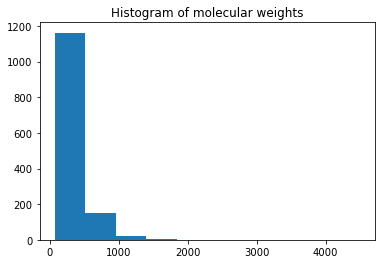

In [18]:
# visualize distribution of molecular weights
plt.hist(df['mol_wt'])
plt.title("Histogram of molecular weights")

df.sort_values("mol_wt").tail(13) # manually inspect for outliers

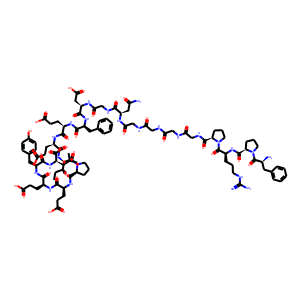

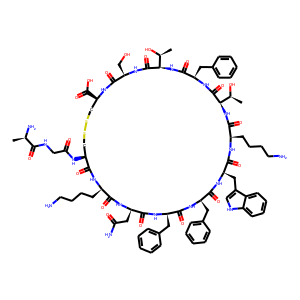

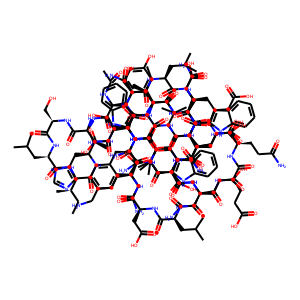

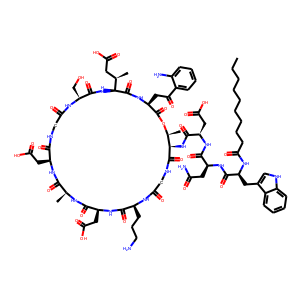

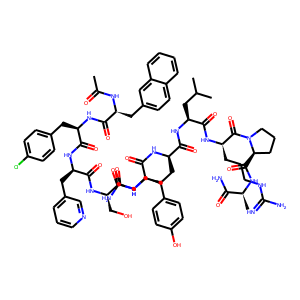

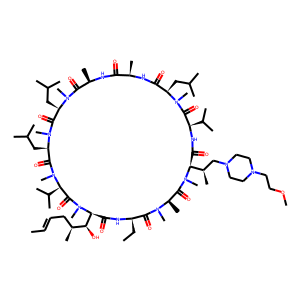

In [30]:
import pandas as pd
from rdkit.Chem import PandasTools
PandasTools.RenderImagesInAllDataFrames(images=True)

# rows = []
# for bCount,bitId in :
#     zid = bitExamples[bitId]
#     if zid in keepMols:
#         info={}
#         fp = Chem.GetMorganFingerprintAsBitVect(keepMols[zid],2,2048,bitInfo=info)
#         aid,rad = info[bitId][0]
#         smi1,smi2 = getSubstructSmi(keepMols[zid],aid,rad)
#         svg = depictBit(bitId,bitExamples,keepMols,molSize=(250,125))
#         rows.append([bitId,zid,svg.data,bCount])
        
# imdf = pd.DataFrame(rows,columns=('Bit','ZincID','drawing','count'))

# imdf

# draw outliers: MW > 1300
idx = df[df["mol_wt"]>1300].index.values
molecules = []
for i in idx:
    molecules.append(Chem.MolFromSmiles(df.iloc[i]["base_rdkit_smiles"]))

display_images(mols_to_pngs(molecules))

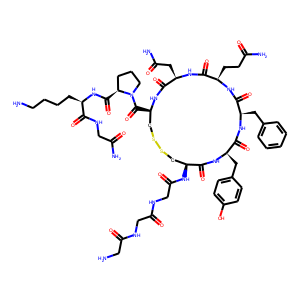

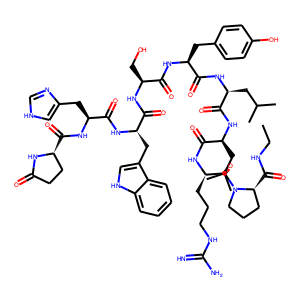

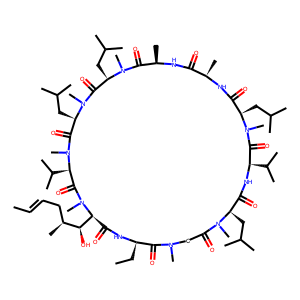

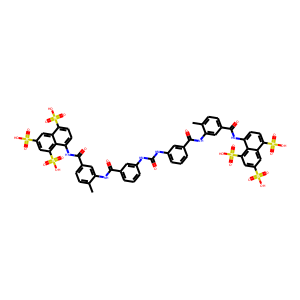

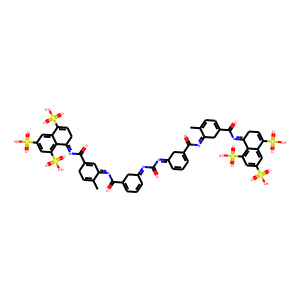

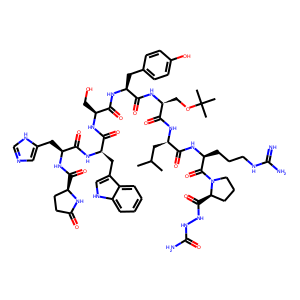

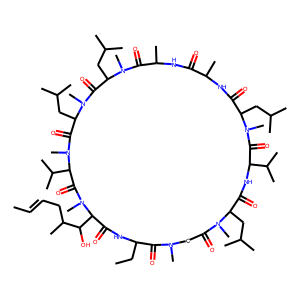

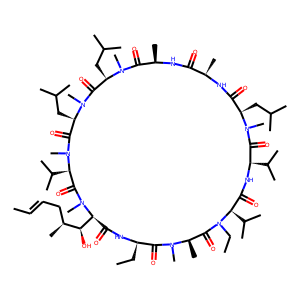

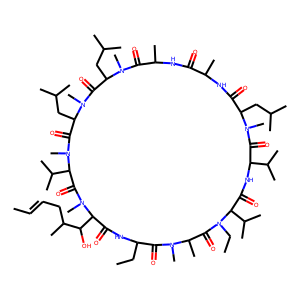

In [33]:
# mw ~ 1200-1300
idx = df[(df["mol_wt"]>1200) & (df["mol_wt"]<1300)].index.values
molecules = []
for i in idx:
    molecules.append(Chem.MolFromSmiles(df.iloc[i]["base_rdkit_smiles"]))

display_images(mols_to_pngs(molecules))

In [34]:
# decide which outliers to filter
print("Num compounds MW > 2000", (df['mol_wt'] > 2000).sum())

# Filter MW > 2000
print("Filtering")
df = df[df['mol_wt'] < 2000]

print("Num compounds MW > 2000", (df['mol_wt'] > 2000).sum())

Num compounds MW > 2000 2
Filtering
Num compounds MW > 2000 0


### Final checks
A common problem with some datasets is missing values or random duplicates. Here we check for those; if they exist they can be removed. pIC50 NaN's were removed per dataset above. If they are removed now, data from the merge will be lost and only compounds with all three measurements would be kept.

In [35]:
print("Length of dataset:", df.shape[0])

print("\nMissing compound_id entries:", df['compound_id'].isna().sum())
print("Duplicate CIDs:", df['compound_id'].duplicated().sum())

print("\nMissing SMILES:", df['base_rdkit_smiles'].isna().sum())
print("Duplicate SMILES:", df['base_rdkit_smiles'].duplicated().sum())

print("\nMissing values should only be transporter-specific now because not all compounds have all measurements:")
print("Other missing values:", df.columns[df.isna().any()].tolist())
print("Missing MRP3 values:", df['pIC50_MRP3'].isna().sum())
print("Missing MRP4 values:", df['pIC50_MRP4'].isna().sum())
print("Missing BSEP values:", df['pIC50_BSEP'].isna().sum())

Length of dataset: 1334

Missing compound_id entries: 0
Duplicate CIDs: 5

Missing SMILES: 0
Duplicate SMILES: 0

Missing values should only be transporter-specific now because not all compounds have all measurements:
Other missing values: ['relation_MRP3', 'pIC50_MRP3', 'active_MRP3', 'relation_MRP4', 'pIC50_MRP4', 'active_MRP4', 'relation_BSEP', 'pIC50_BSEP', 'active_BSEP']
Missing MRP3 values: 537
Missing MRP4 values: 520
Missing BSEP values: 20


In [36]:
# some duplicate compound ids, but have individual smiles strings, some different MW's and
# are from different datasources so leave as-is for now. Explore this later.
df[df.duplicated(subset = "compound_id", keep = False)].sort_values("compound_id")

,base_rdkit_smiles,relation_MRP3,pIC50_MRP3,active_MRP3,relation_MRP4,pIC50_MRP4,active_MRP4,relation_BSEP,pIC50_BSEP,active_BSEP,compound_id,Morgan,SMDC,Prop,mol_wt
1052,CN1[C@H]2C[C@H](OC(=O)[C@H](CO)c3ccccc3)C[C@@H...,NaN,NaN,NaN,NaN,NaN,NaN,<,3.000000,Inactive,3000322,False,False,False,303.147058
1176,CN1[C@H]2C[C@H](OC(=O)[C@H](CO)c3ccccc3)C[C@@H...,NaN,NaN,NaN,NaN,NaN,NaN,<,3.000000,Inactive,3000322,False,False,False,303.147058
543,Nc1cc(N2CCCCC2)nc(N)[n+]1[O-],<,3.880000,Inactive,<,3.880000,Inactive,<,3.869666,Inactive,4201,True,True,False,209.127660
873,N=c1nc(N2CCCCC2)cc(N)n1O,NaN,NaN,NaN,NaN,NaN,NaN,<,3.000000,Inactive,4201,False,False,False,209.127660
514,O=C(Nc1cccc2c(=O)cc(-c3nn[nH]n3)oc12)c1ccc(OCC...,,4.803524,Active,,4.747673,Active,,5.530000,Active,4887,True,True,False,481.175004
1191,O=C(Nc1cccc2c(=O)cc(-c3nnn[nH]3)oc12)c1ccc(OCC...,NaN,NaN,NaN,NaN,NaN,NaN,,6.000000,Active,4887,False,False,False,481.175004
305,Cc1ccc(C(=O)Nc2ccc(S(=O)(=O)O)c3cc(S(=O)(=O)O)...,,5.480000,Active,NaN,NaN,NaN,NaN,NaN,NaN,5361,False,False,False,1296.046908
475,CC1=CCC(C(=O)/N=C2\CC=C(S(=O)(=O)O)c3cc(S(=O)(...,<,3.880000,Inactive,<,3.880000,Inactive,,3.731582,Inactive,5361,True,False,False,1296.046908
722,C=C[C@]1(C)C[C@@H](OC(=O)NC(=O)c2ccc(N)nn2)[C@...,<,4.000000,Inactive,,4.300000,Active,,4.570000,Active,681,False,True,True,500.263485
883,NCCc1ccc(O)c(O)c1,NaN,NaN,NaN,NaN,NaN,NaN,<,3.000000,Inactive,681,False,False,False,153.078979


### Step 9: Save dataframes

In [37]:
df3_cur.to_csv("MRP3_curated.csv")
df4_cur.to_csv("MRP4_curated.csv")
dfb_cur.to_csv("BSEP_curated.csv")
df.to_csv("transporters_pIC50_crada_merged.csv")
df_nonprop = df[df["Prop"]==0].copy()
df_nonprop.drop(columns = ("Prop"), inplace = True)
df_nonprop.to_csv("transporters_pIC50_merged.csv")

In [38]:
data = [df3_cur["base_rdkit_smiles"], df4_cur["base_rdkit_smiles"], dfb_cur["base_rdkit_smiles"]]
headers = ["MRP3", "MRP4", "BSEP"]
smiles_csv = pd.concat(data, axis=1, keys=headers)
smiles_csv.to_csv("transporters_smiles_crada.csv")

# Visualize data
- Compound overlaps
- non-censored pIC50 value distributions
### Here outlier pIC50 values can also be filtered before continuing to model!

In [39]:
import seaborn as sns
import numpy as np
import matplotlib_venn as mpv

sns.set_context("poster")
sns.set_style("whitegrid")
sns.set_palette("Set2")
pal = sns.color_palette()
plt.rcParams['figure.figsize'] = [10,10]

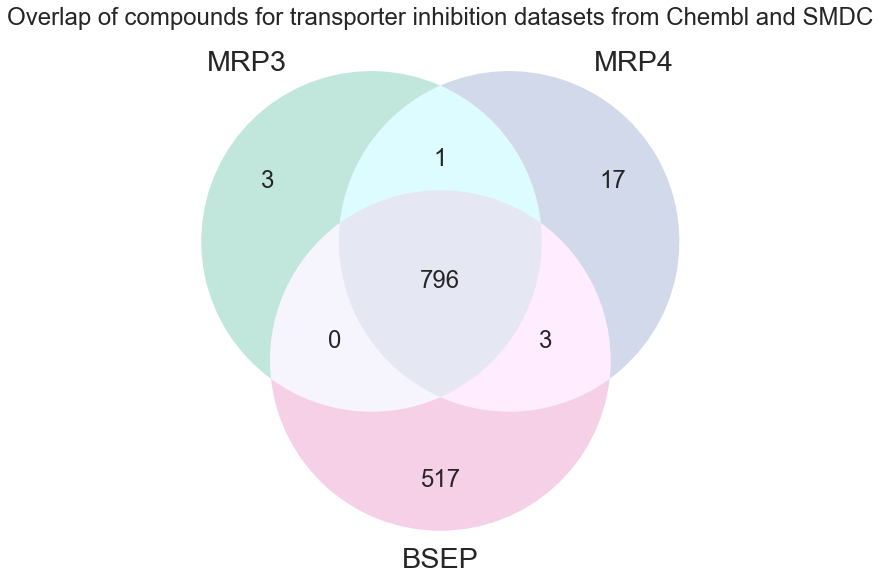

In [40]:
mpv.venn3_unweighted([set(smiles_csv["MRP3"]), set(smiles_csv["MRP4"]), set(smiles_csv["BSEP"])], set_labels = ("MRP3", "MRP4", "BSEP"), set_colors = (pal[0], pal[2], pal[3]))
plt.title('Overlap of compounds for transporter inhibition datasets from Chembl and SMDC');

In [41]:
# look at relation column
print(df3_cur.relation.unique())

['<' '']


96


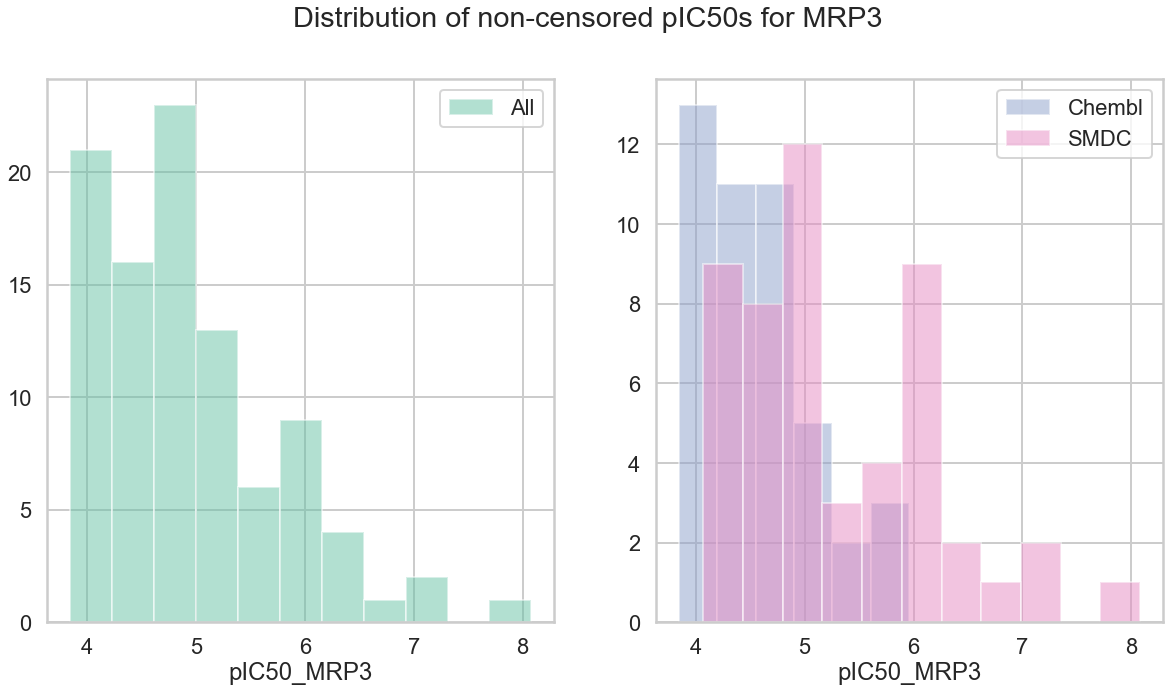

In [42]:
# visualize distribution of compounds
unc = df3_cur[df3_cur.relation != '<'] # remove censored compounds
print(len(unc))

# plot multiple plots

# kwargs are keyword arguments that can be passed from place to place with **
# they just save typing if you want everything the same on several subplots

# here i'm saying i want no KDE on my distplots, and for the histogram part 
# of the distplot, i want the alpha to be 0.5
kwargs = dict(kde=False, hist_kws={'alpha':.5})

# initialize the plot with a figure and axes. 
# axes are determined by the first two numbers plt.subplot(numrows, num cols)
# i often use this formula for a single plot since it allows a lot of flexibility 
# over what you want to display on the plots with fig and ax handles.
fig, ax = plt.subplots(1,2, figsize = (20,10))

# for seaborn you refer to which axis you want to plot on at the end of the 
# command. for only one row or column, they are single indices: ax[0]
# for two or more they're dual indices ax[0,0]. You can alternatively 
# call ax = axes.flatten() to refer to multiple rows and columsn by a single 
# index. This is useful for filling in the rows and columns with a for loop.
# for matplotlib you can call functions directly on the ax object: ax[0].scatter(...) 
sns.distplot(unc['pIC50_MRP3'], color = pal[0], bins = 11, label = "All",  **kwargs, ax = ax[0])

# sns is pretty interchangeable with matplotlib, so you can do some things
# to a subplot directly like add a legend:
ax[0].legend()

# when you're done with the first plot just move on to the second:\
# note the **kwargs here and in the previous one
sns.distplot(unc["pIC50_MRP3"][unc["SMDC"]==0], color = pal[2],            label="Chembl", **kwargs, ax = ax[1])
sns.distplot(unc["pIC50_MRP3"][unc["SMDC"]==1], color = pal[3], bins = 11, label="SMDC",   **kwargs, ax = ax[1])
ax[1].legend();

# for overall figure things not tied to a certain subplot you can talk to fig:
fig.suptitle('Distribution of non-censored pIC50s for MRP3');

In [43]:
print(df4_cur.relation.unique())

['<' '']


212


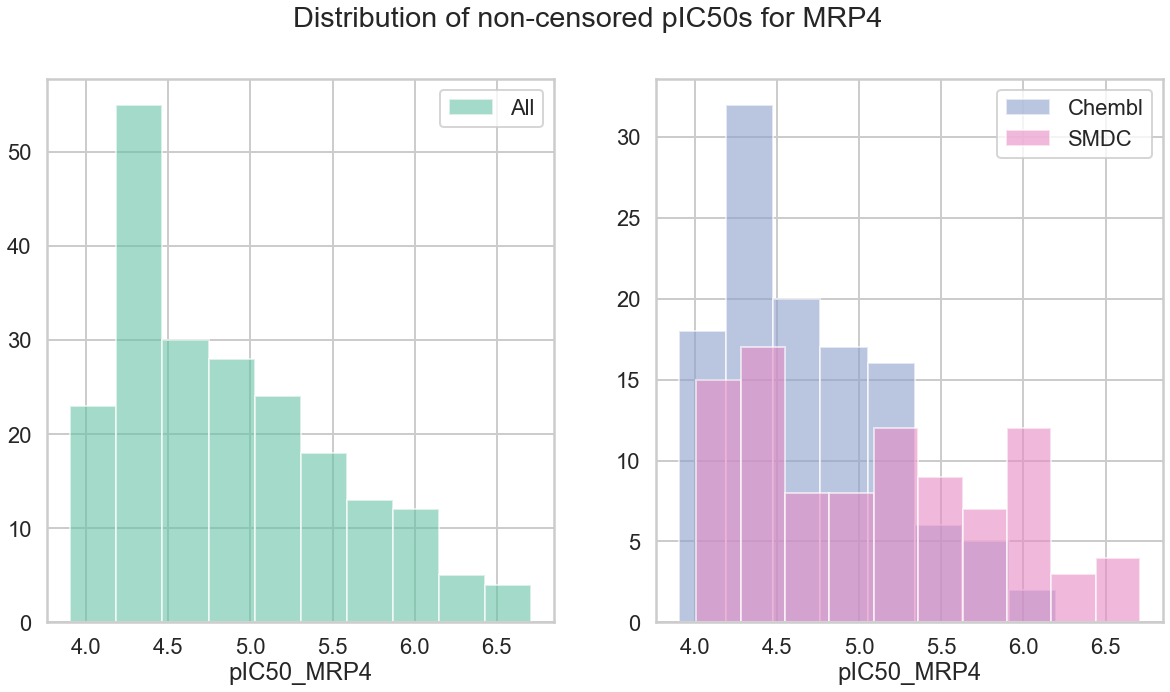

In [44]:
unc = df4_cur[df4_cur.relation != '<']
print(len(unc))

kwargs = dict(kde=False, hist_kws={'alpha':.6})

fig, ax = plt.subplots(1,2, figsize = (20,10))
sns.distplot(unc['pIC50_MRP4'],                 color = pal[0], bins = 10, label = "All",  **kwargs, ax = ax[0])
ax[0].legend()
sns.distplot(unc["pIC50_MRP4"][unc["SMDC"]==0], color = pal[2],            label="Chembl", **kwargs, ax = ax[1])
sns.distplot(unc["pIC50_MRP4"][unc["SMDC"]==1], color = pal[3], bins = 10, label="SMDC",   **kwargs, ax = ax[1])
ax[1].legend();
fig.suptitle('Distribution of non-censored pIC50s for MRP4');

In [45]:
print(dfb_cur.relation.unique())

['<' '' '>']


576


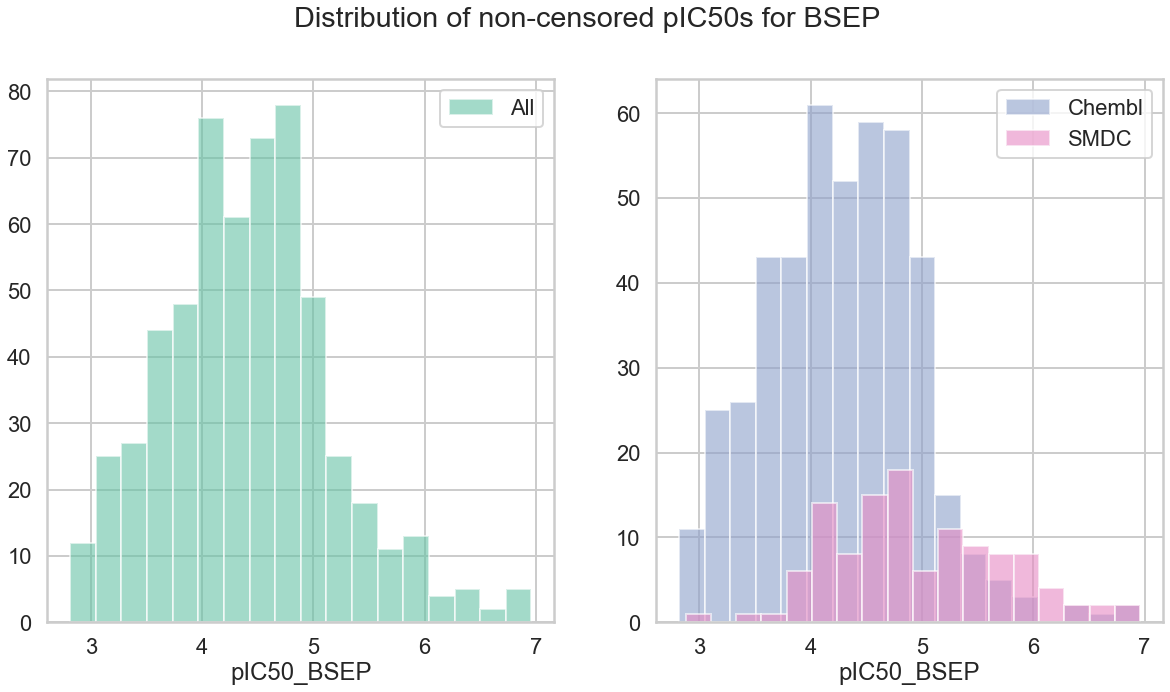

In [46]:
unc = dfb_cur[(dfb_cur.relation != '<') & (dfb_cur.relation !='>')]
print(len(unc))

kwargs = dict(kde=False, hist_kws={'alpha':.6})

fig, ax = plt.subplots(1,2, figsize = (20,10))
sns.distplot(unc['pIC50_BSEP'],                 color = pal[0], bins = 18, label = "All",  **kwargs, ax = ax[0])
ax[0].legend()
sns.distplot(unc["pIC50_BSEP"][unc["SMDC"]==0], color = pal[2],            label="Chembl", **kwargs, ax = ax[1])
sns.distplot(unc["pIC50_BSEP"][unc["SMDC"]==1], color = pal[3], bins = 18, label="SMDC",   **kwargs, ax = ax[1])
ax[1].legend();
fig.suptitle('Distribution of non-censored pIC50s for BSEP');